In [1]:
%cd ~/repo/protein-transfer

/home/t-fli/repo/protein-transfer


In [2]:
from scr.utils import pickle_load

In [8]:
from scr.params.emb import TRANSFORMER_INFO

In [3]:
folder_path = "results/train_val_test/proeng/gb1/low_vs_high"

In [9]:
import os
from glob import glob
import numpy as np

In [45]:
def parse_result_dicts(folder_path: str, metric_list: list[str] = ["train_mse", "test_ndcg", "test_rho"]):
    pkl_list = glob(f"{folder_path}/*.pkl")
    print(len(pkl_list))
    
    # get the max layer number for the array
    model_name, _, _ = os.path.splitext(os.path.basename(pkl_list[0]))[0].split("-")
    max_layer_numb = TRANSFORMER_INFO[model_name][1] + 1
    
    output_numb_dict = {metric: np.zeros([max_layer_numb]) for metric in metric_list}

    for pkl_file in pkl_list:
        layer_numb = int(os.path.splitext(os.path.basename(pkl_file))[0].split("-")[1].split("_")[-1])
        result_dict = pickle_load(pkl_file)
        
        for metric in metric_list:
            subset, kind = metric.split("_")
            if kind == "rho":
                output_numb_dict[metric][layer_numb] = result_dict[subset][kind][0]
            else:
                output_numb_dict[metric][layer_numb] = result_dict[subset][kind]
         #print(output_numb_dict[metric])
    return output_numb_dict

In [46]:
output_numb_dict = parse_result_dicts(folder_path, )

34


In [47]:
output_numb_dict.keys()

dict_keys(['train_mse', 'test_ndcg', 'test_rho'])

In [49]:
import matplotlib.pyplot as plt

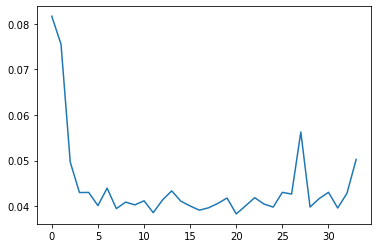

In [51]:
plt.plot(output_numb_dict["train_mse"])

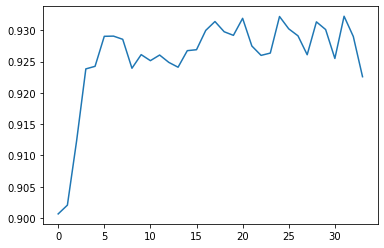

In [52]:
plt.plot(output_numb_dict["test_ndcg"])

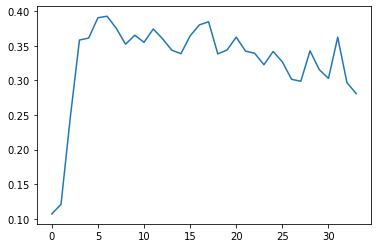

In [53]:
plt.plot(output_numb_dict["test_rho"])